# Doorbell Detection Model Training

This notebook trains a machine learning model to detect doorbell sounds from audio recordings.

## 1. Setup and Imports

Import all necessary libraries

In [1]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Import our custom audio processing utilities
from doorbell_detection_utils import process_dataset, extract_features


2025-03-09 13:41:25.729458: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-09 13:41:25.729958: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-09 13:41:25.732328: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-09 13:41:25.738840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741524085.749696  201810 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741524085.75

## 2. Configure Directories and Parameters

Set up paths and audio processing parameters.

In [2]:
# Define parameters for audio processing and feature extraction
sample_rate = 16000
segment_duration = 1.0    # in seconds
hop_duration = 0.5        # in seconds
n_mfcc = 20               # Number of MFCC coefficients
n_mels = 40               # Number of Mel bands
n_fft = 1024              # FFT window size
hop_length = 512          # Hop length for FFT
augment = True            # Whether to apply data augmentation
n_max_background_samples = 2000  # Maximum number of negative examples
n_max_mixed_samples_coef = 0.3   # Coefficient to calculate the maximum number of mixed examples

## 3. Load and Process Audio Data

Now we'll process the audio files and extract features for our model.

In [3]:
# Set paths for audio files
audio_samples_path = './audio_samples'
os.makedirs(audio_samples_path, exist_ok=True)
print(f"Audio samples directory: {audio_samples_path}")

# Check if doorbell audio file exists
doorbell_path_mp3 = os.path.join(audio_samples_path, 'doorbell.mp3')
doorbell_path_wav = os.path.join(audio_samples_path, 'doorbell.wav')
if os.path.exists(doorbell_path_mp3):
    doorbell_path = doorbell_path_mp3
elif os.path.exists(doorbell_path_wav):
    doorbell_path = doorbell_path_wav
else:
    print("ERROR: doorbell.mp3 or doorbell.wav not found!")
    print("Please add your doorbell recording as 'doorbell.mp3' or 'doorbell.wav' in the audio_samples folder")
    print("The model training will not be effective without a doorbell sample.")
    doorbell_path = None
    
if doorbell_path:
    print(f"Doorbell sample found: {doorbell_path}")
    # Process audio data and extract features
    features, labels = process_dataset(
        doorbell_path=doorbell_path,
        audio_dirs=[audio_samples_path],
        sample_rate=sample_rate,
        segment_duration=segment_duration,
        hop_duration=hop_duration,
        n_mfcc=n_mfcc,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length,
        augment=augment,
        mix_background=True,
        mix_ratio_range=(0.1, 0.5),                     # Proportion mix of background and doorbell
        max_background_samples=n_max_background_samples, # Limit of negative examples
        max_mixed_samples=n_max_background_samples*n_max_mixed_samples_coef # Mixed examples to generate
)
else:
    print("ERROR: doorbell.mp3 or doorbell.wav not found!")
    print("Please add your doorbell recording as 'doorbell.mp3' or 'doorbell.wav' in the audio_samples folder")
    print("The model training will not be effective without a doorbell sample.")

Audio samples directory: ./audio_samples
Doorbell sample found: ./audio_samples/doorbell.mp3
Processing doorbell sample: ./audio_samples/doorbell.mp3
Dataset: 603 positives, 1000 negatives. Ratio 1:1.7


## 4. Explore Processed Data

Let's examine the extracted features and check the balance of our dataset.

In [4]:
# Display information about the dataset
print(f"Total samples: {len(features)}")
print(f"Number of features per sample: {features.shape[1]}")
print(f"Doorbell samples: {np.sum(labels)}")
print(f"Background noise samples: {len(labels) - np.sum(labels)}")
print(f"Class balance: {np.sum(labels) / len(labels):.2%} doorbell vs {1 - np.sum(labels) / len(labels):.2%} background")

Total samples: 1603
Number of features per sample: 176
Doorbell samples: 603
Background noise samples: 1000
Class balance: 37.62% doorbell vs 62.38% background


## 5. Split Data into Training and Validation Sets

We'll use stratified sampling to maintain the class distribution.

In [5]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Training set distribution: {np.sum(y_train)} doorbell, {len(y_train) - np.sum(y_train)} background sounds")
print(f"Validation set distribution: {np.sum(y_val)} doorbell, {len(y_val) - np.sum(y_val)} background souds")


Training set: 1282 samples
Validation set: 321 samples
Training set distribution: 482 doorbell, 800 background sounds
Validation set distribution: 121 doorbell, 200 background souds


## 6. Define the Model Architecture

We'll create a simple neural network with dropout for regularization.

In [6]:
# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print model summary
model.summary()

/home/enrique_miravet/enrique/timbre_ia/model_training/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1741524094.540821  201810 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        11,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,441 (52.50 KB)

 Trainable params: 13,441 (52.50 KB)

 Non-trainable params: 0 (0.00 B)

## 7. Train the Model

We'll use early stopping to prevent overfitting and learning rate reduction to improve convergence.

In [7]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.0001,
        verbose=1
    )
]

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5351 - loss: 63.3317 - precision: 0.3582 - recall: 0.3528 - val_accuracy: 0.9595 - val_loss: 0.6440 - val_precision: 0.9576 - val_recall: 0.9339 - learning_rate: 0.0010
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6289 - loss: 24.1036 - precision: 0.5054 - recall: 0.4881 - val_accuracy: 0.9470 - val_loss: 0.5870 - val_precision: 0.9727 - val_recall: 0.8843 - learning_rate: 0.0010
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7324 - loss: 8.2296 - precision: 0.6522 - recall: 0.6412 - val_accuracy: 0.9720 - val_loss: 0.4788 - val_precision: 0.9590 - val_recall: 0.9669 - learning_rate: 0.0010
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8210 - loss: 3.4754 - precision: 0.7544 - recall: 0.7772 - val_accuracy: 0.9720 - val_loss: 0.4261 - val_precision: 0.9667 - val_recall: 0.9587 - learning_rate: 0.0010
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8

## 8. Evaluate the Model

Let's check how well our model performs by analyzing metrics and visualizing results.

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Model Evaluation:
Confusion Matrix:
[[200   0]
 [  0 121]]
True Positives: 121
False Positives: 0
True Negatives: 200
False Negatives: 0
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


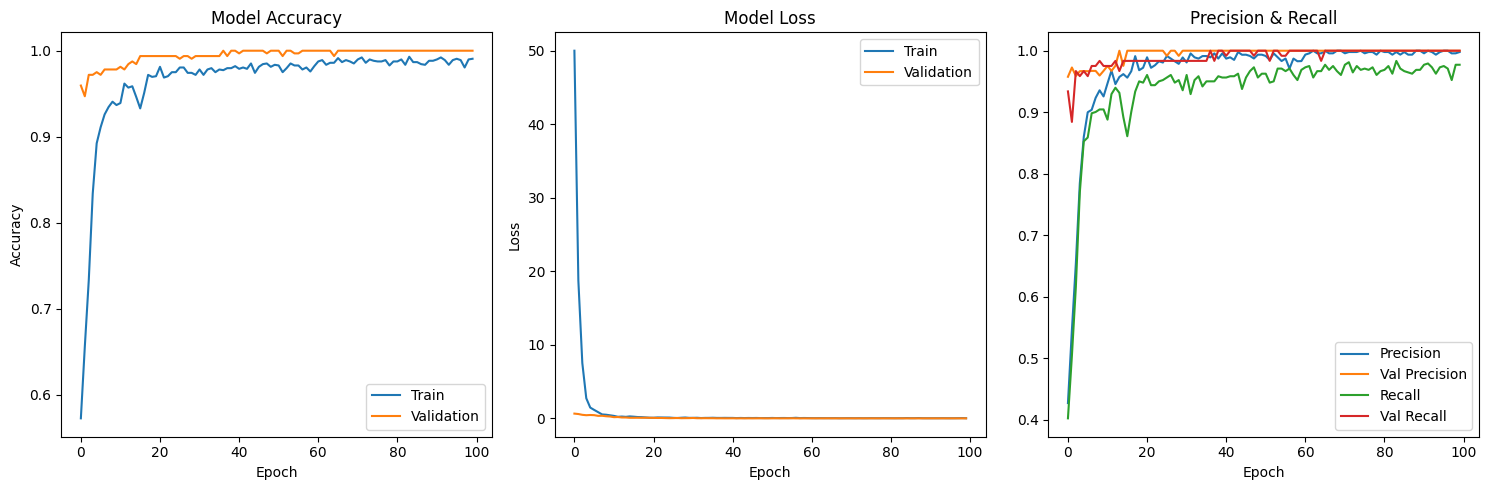

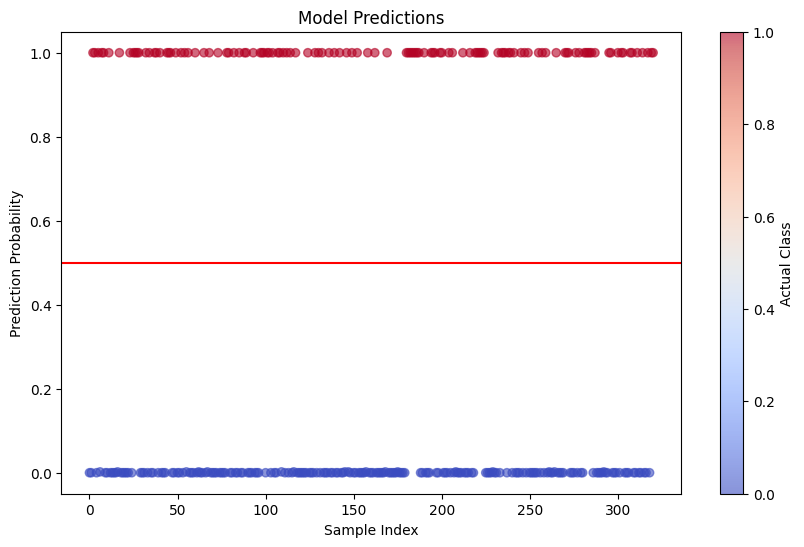

In [8]:
# Make predictions on validation set
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Print metrics
print("\nModel Evaluation:")
print("Confusion Matrix:")
print(conf_matrix)
print(f"True Positives: {conf_matrix[1][1]}")
print(f"False Positives: {conf_matrix[0][1]}")
print(f"True Negatives: {conf_matrix[0][0]}")
print(f"False Negatives: {conf_matrix[1][0]}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 3, 3)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Precision & Recall')
plt.xlabel('Epoch')
plt.legend(['Precision', 'Val Precision', 'Recall', 'Val Recall'], loc='lower right')

plt.tight_layout()
plt.show()

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_val)), y_pred_prob, c=y_val, cmap='coolwarm', alpha=0.6)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.title('Model Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Prediction Probability')
plt.colorbar(label='Actual Class')
plt.show()

## 9. Save the Model

Let's save our trained model for deployment.

In [9]:
# Create directory for models if it not exists
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Save in H5 format (TensorFlow/Keras)
model_path = os.path.join(models_dir, 'doorbell_detector.h5')
model.save(model_path)
print(f"Model saved to {model_path}")

# Convert to TFLite format (embedded devices)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = os.path.join(models_dir, 'doorbell_detector.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
print(f"TFLite model saved to {tflite_model_path}")

Model saved to ../models/doorbell_detector.h5
INFO:tensorflow:Assets written to: /tmp/tmphsf3k0_z/assets


INFO:tensorflow:Assets written to: /tmp/tmphsf3k0_z/assets


Saved artifact at '/tmp/tmphsf3k0_z'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 176), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132085072525648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132085072526800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132085072526224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132085072525072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132085067285904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132085067286672: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite model saved to ../models/doorbell_detector.tflite


W0000 00:00:1741524105.445900  201810 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1741524105.445914  201810 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-09 13:41:45.446108: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphsf3k0_z
2025-03-09 13:41:45.446387: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-09 13:41:45.446393: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmphsf3k0_z
I0000 00:00:1741524105.448724  201810 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-03-09 13:41:45.449200: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-09 13:41:45.467795: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmphsf3k0_z
2025-03-09 13:41:45.472859: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 